In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

# Position Encoding

> The positional encodings have the same dimension dmodel as the embeddings, so that the two can be summed. (page 6)

![image.png](images/position_encoding.png)

In [ ]:
# follow the formula
# pos: position
# i: from 0 to dmodel, control the period 
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], 
        np.arange(d_model)[np.newaxis, :], # i: from 0 to dmodel
        d_model)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

# Masking

In [ ]:
# padding mask: to ignore padding
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

# look-ahead mask: for decoder: the decoder should not use the information from following wrods
def create_look_ahead_mask(size):
    # tf.linalg.band_part: Copy a tensor setting everything outside a central band in each innermost matrix
    # -1: keep lower
    # 0: remove all upper
    # mask is a matrix (size,size)
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask 

# Scaled Dot Product Attention

![image.png](images/scale_dot_product_attention.png)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    dot product between q and k provide the similarity of q and k
    
    q: matrix of a set of queries (num_query, dk)
    k: matrix of key (num_keys, dk)
    v: matrix of values (num_values, dv)
    num_values==num_keys
    
    mask: "broadcastable"
    """
    qk = tf.matmul(q, k, transpose_b=True)
    # dk: the last dimension of k, q
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = qk/tf.math.sqrt(dk)
    
    # add the mask to the scaled tensor.
    # mask is "broadcastable"
    if mask is not None:
        # if there is a mask, set the value to -inf
        scaled_attention_logits += (mask * -1e9)  
    
    # "axis=-1": the last dimension is num_keys
    # the attention is distributed in all the keys and sum to 1
    # attention_weights: (num_query, num_keys) 
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    # output shape (num_query, dv)
    output = tf.matmul(attention_weights, v)
    
    # output (num_query, dv): each query gets a value vector in dv
    # attention_weights (num_query, num_keys):
    #     for each pair of query and key, we can find a weight in the matrix
    return output, attention_weights
    

# Multi-head Attention

![image](images/multi_head_attention.png)

Q, K, V: (..., dmodel)
Use WQ WK WV to project them to dk, dk, dv space

In [ ]:
# define layer in Tensforflow
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        # divide the entire space into num_heads 
        assert d_model % self.num_heads == 0
        
        # depth == dk == dv
        self.depth = d_model // self.num_heads
    
        # wq is the concatenated result of WQi in paper
        # paper's formula: multiply by divided matrix WQi
        # here: multiply by WQ and divide the result
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth)."""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # (batch_size, num_heads, seq_len, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        """
        input shape:
        q: (batch_size, seq_len(num_query), input_dim_q)
        k: (batch_size, seq_len(num_key), input_dim_k)
        v: (batch_size, seq_len(num_value), input_dim_v)
        
        pay attention to batch_size, cannot skip
        """
        batch_size = tf.shape(q)[0]
        
        # here the q, k, v are projected result
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        # divide the result to the input of dot product attention
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        # (batch_size, seq_len_q, d_model)
        # for each query, get a weighted value (in dmodel space)
        output = self.dense(concat_attention)  

        return output, attention_weights

# Point-wise Feed Forward Network

![Image](images/point_wise_feed_forward_network.png)

In [ ]:
# 512 -> 2048 -> 512 in paper
# dmodel -> dff -> dmodel
def point_wise_feed_forward_network(d_model, dff):
      return tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
          tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
      ])

# Encoder Layer and Encoder

![image](images/encoder.png)

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        # inputs for v, q, k are all x
        mha_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        mha_output = self.dropout1(mha_output, training=training)
        out1 = self.layernorm1(x + mha_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, 
                 dff,
                 input_vocab_size, # the size of the dictionary (how many words in one-hot coding)
                 maximum_position_encoding, # maximum_position
                 rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        
        # word embedding
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        # calculated result
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)

        # a list of encoder layers
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        # ??? is for weighted sum? And why?
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        # encoder layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

# Decoder Layer and Decoder

![image](images/decoder.png)

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        # v: encoder output
        # k: encoder output
        # q: out1
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
        # return attention weights block
        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads,
                 dff,
                 target_vocab_size, # num of words in output dictionary
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        # dictionary format
        attention_weights = {}

        # word embedding for the previous output
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            # block1, bloack2: attention_weight_block
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)
            # save into dictionary
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

# Transformer

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                 target_vocab_size,
                 pe_input, # max position
                 pe_target, # max position
                 rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self,
             inputs, 
             targets, # generated outputs
             training, enc_padding_mask, 
             look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inputs, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            targets, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # a priction of target_vocab_size for each word
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

# Data

From [this file](http://https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb)

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [ ]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)


In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
        lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
    return lang1, lang2

def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

In [ ]:
MAX_LENGTH = 40
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                          tf.size(y) <= max_length)

In [ ]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

# Train

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

EPOCHS = 20

## Learning Rate Schedule

![image.png](images/optimizer.png)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

## Loss

In [ ]:
# define loss for training 
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') # use reduction="none" for adding mask

def loss_function(real, pred):
    # mask the 0 elements
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    # mean reduce
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
# the metrices are used for check the loss and accuracy during training
# for each time it's called, it update the metric
# in this way, one can provide average loss across batches
# for each epoch, call XX.reset_states() to reinitialize
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [ ]:
def create_masks(inputs, targets):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inputs)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inputs)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(targets)[1])
    dec_target_padding_mask = create_padding_mask(targets)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask


In [ ]:
# check point
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

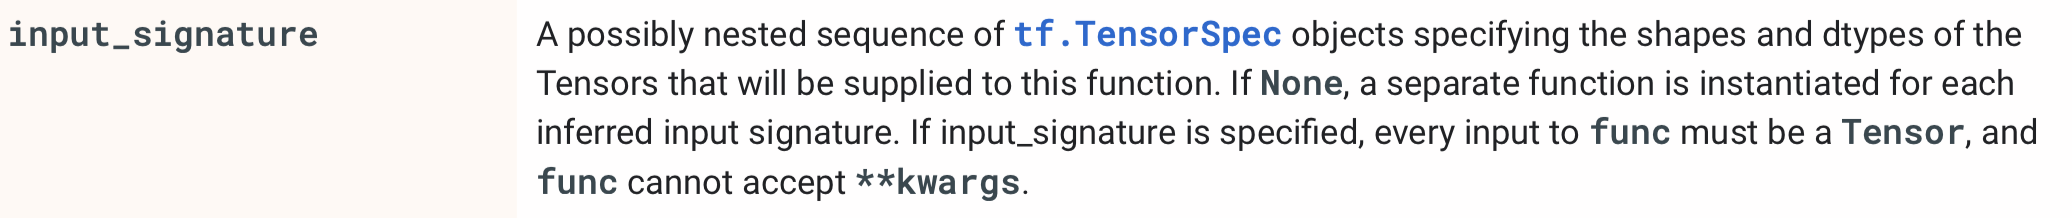

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    # tar_real is right-shift by 1 from tar_inp
    # tar_real contains the next token
    
    tar_inp = tar[:, :-1] 
    tar_real = tar[:, 1:] 
    # Mask
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    
    with tf.GradientTape() as tape:
        # tar_inp is the generated targets during the real work
        # during training, it's set to be the correct input
        # (assume the previous predictions are perfect)
        
        
        predictions, _ = transformer(inp, tar_inp, 
                                     True, # training 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    # enumerate generate index, item for each time
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

    if batch % 50 == 0:
        print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
            epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                         train_loss.result(), 
                                                         train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

# Reference  
[Transformer model for language understanding](https://www.tensorflow.org/tutorials/text/transformer)  
[Attention is All You Need](https://arxiv.org/abs/1706.03762)